<a href="https://colab.research.google.com/github/ksumarshmallow/Practical-BF/blob/main/CNN_Plasmodium_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import sys
import shutil
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile

from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
from sklearn.datasets import load_files

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

import cv2
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cell-images-for-detecting-malaria:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F87153%2F200743%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240924%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240924T085221Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D750761e5dc725c3437e90b48640d6fefbfff819357703ea72ca9ab78c2eb17adab035bbad8504595fb9974f1986f6685f1f1f7786f9cc1907072cc3c84ce977c7ca20bca8862c76db73121d0c8d04078c2272842e22bd8343f22f3728f6b5712d6b3968789017dd1ac3b209e33f9fe8242d7e991fa0b8a4e00d1b3c4c887e9de1e69d397464e4154053a25238bca65ca1007d8a887f5ac5b9c249763f7bdd718719511538b52266abbefa16c0f6c34b8aef35d7e7e9c3209d8ab8845150bd4bee61b135202bf0bbfb6509e93266f122d4a0f4dc43fbcec6181a09172e4ebdc8dbd8ec998b14d8d33ad94deb33888bcfed51a84758095a1fab8d8ace1bcc8def8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 708172590 bytes downloaded
Downloaded and uncompressed: cell-images-for-detecting-malaria
Data source import complete.


In [15]:
SEED = 42
dir = "../input/cell-images-for-detecting-malaria/cell_images/cell_images"

# Обзор проекта по классификации малярии¶

## Введение
Этот проект посвящен разработке модели глубокого обучения для классификации изображений клеток малярии. Малярия, опасное для жизни заболевание, вызываемое паразитами *Plasmodium*, является одной из основных проблем глобального здравоохранения. Только в 202 году в мире было зарегистрировано около 247 миллионов случаев заболевания малярией, что привело к смерти около 619 000 человек, причем большинство из них произошло в странах Африки к югу от Сахары. - ВОЗ

## Цель
Целью данного проекта является создание модели, способной различать два ключевых класса:
1. Неинфицированные клетки: Здоровые эритроциты без малярийной инфекции.
2. Паразитированные клетки: Красные кровяные тельца, зараженные паразитами *Plasmodium*.

## Набор данных
Набор данных представляет собой коллекцию изображений, на которых изображены как неинфицированные, так и паразитированные клетки. Она взята из официальной базы данных **NIH Malaria Datasets** и содержит в общей сложности 27 558 изображений.

## Методология
Мы будем использовать методы глубокого обучения, в частности конволюционные нейронные сети (CNN), для обучения модели, которая может автоматически узнавать и различать признаки, связанные с инфицированными и неинфицированными клетками. Модель будет обучена на наборе данных с метками и оценена на отдельном тестовом наборе для оценки эффективности классификации.

## Значение
Автоматизированная классификация клеток малярии может ускорить процесс диагностики, особенно в регионах с ограниченным доступом к медицинским ресурсам. Успешная реализация этой модели может способствовать повышению эффективности и точности

# Dataset Loading

In [5]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

_,_, labels_name = load_dataset(dir)
print('Loading complete!')

Loading complete!


In [6]:
infected = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/')
uninfected = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/')

In [8]:
from tqdm import tqdm

In [9]:
data = []
labels = []

for i in tqdm(infected, colour="GREEN"):
    try:
        image = cv2.imread(dir+"/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        data.append(np.array(resize_img))
        labels.append(1)
    except AttributeError:
        print('')

for u in tqdm(uninfected, colour="GREEN"):
    try:
        image = cv2.imread(dir+"/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        data.append(np.array(resize_img))
        labels.append(0)
    except AttributeError:
        print('')

 98%|█████████▊| 13512/13780 [00:13<00:00, 1094.79it/s]

 98%|█████████▊| 13550/13780 [00:12<00:00, 1136.66it/s]

100%|██████████| 13780/13780 [00:13<00:00, 1050.62it/s]


In [10]:
images = np.array(data)
labels = np.array(labels)

np.save('Cells' , images)
np.save('Labels' , labels)

In [27]:
np.unique(labels, return_counts = True)

(array([0, 1], dtype=int32), array([13779, 13779]))

In [11]:
print('Cells : {} | labels : {}'.format(images.shape , labels.shape))

Cells : (27558, 50, 50, 3) | labels : (27558,)


## Visualization a portion of sample training dataset

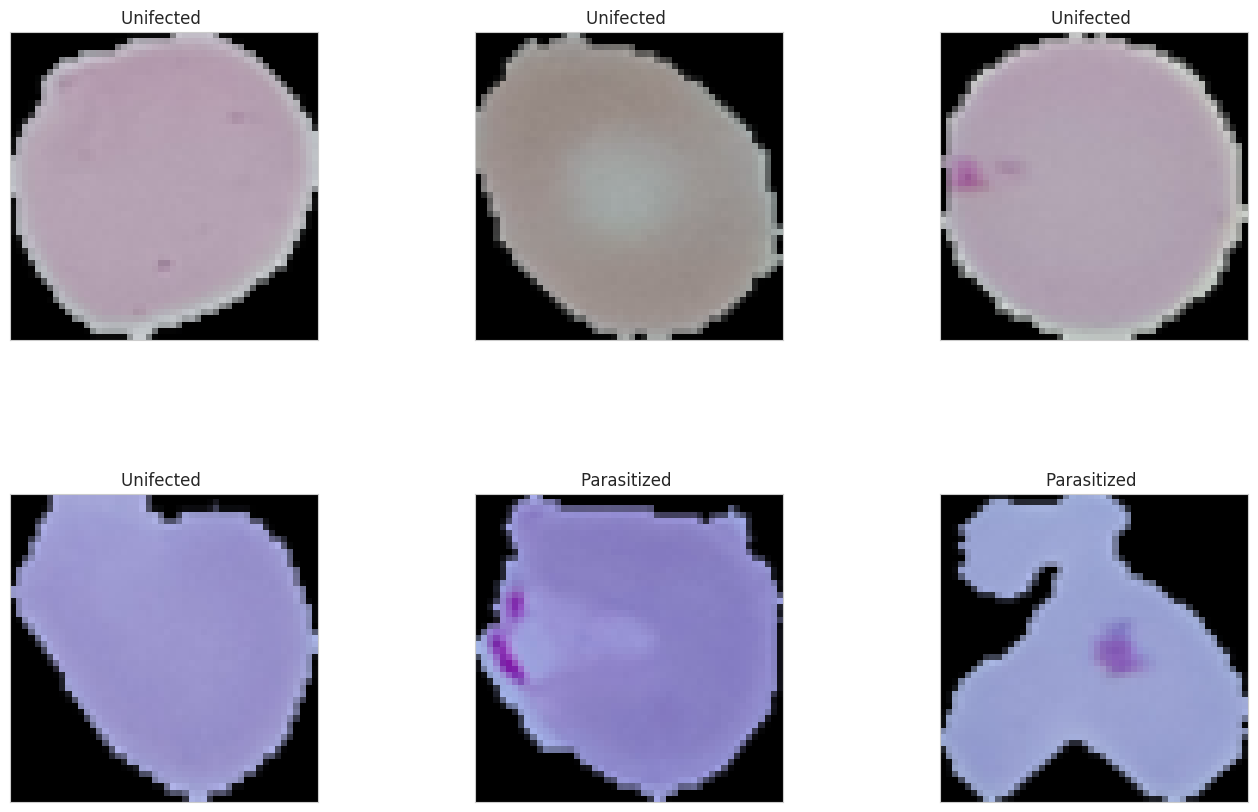

In [12]:
plt.figure(1 , figsize = (16 , 10))
n = 0
for i in range(6):
    n += 1
    r = np.random.randint(0 , images.shape[0] , 1)
    plt.subplot(2 , 3, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(images[r[0]])
    plt.title('{} '.format( 'Parasitized' if labels[r[0]] == 1 else  'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [13]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images / 255

# Spliting dataset into train, test , validation dataset

In [16]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(images, labels,
                                             test_size = 0.2,
                                             random_state = SEED)

eval_x , test_x , eval_y , test_y = train_test_split(x, y,
                                                    test_size = 0.5,
                                                    random_state = SEED)

In [17]:
print('train data shape {} ,eval data shape {} , test data shape {}'.format(train_x.shape,
                                                                           eval_x.shape ,
                                                                           test_x.shape))

train data shape (22046, 50, 50, 3) ,eval data shape (2756, 50, 50, 3) , test data shape (2756, 50, 50, 3)


In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,849 (4.36 MB)

 Trainable params: 1,142,849 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [20]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.987 ):
            print("\nReached 98.7% accuracy so cancelling training!")
            self.model.stop_training = True

In [21]:
callbacks=myCallback()
history = model.fit(train_x,train_y,
        batch_size = 80,
        epochs=5,
        validation_data=(eval_x, eval_y),
        callbacks = callbacks,
        verbose=1, shuffle=True)

Epoch 1/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6264 - loss: 0.6288 - val_accuracy: 0.9100 - val_loss: 0.2423
Epoch 2/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9231 - loss: 0.2184 - val_accuracy: 0.9481 - val_loss: 0.1599
Epoch 3/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9493 - loss: 0.1573 - val_accuracy: 0.9507 - val_loss: 0.1540
Epoch 4/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9542 - loss: 0.1403 - val_accuracy: 0.9539 - val_loss: 0.1524
Epoch 5/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9573 - loss: 0.1315 - val_accuracy: 0.9532 - val_loss: 0.1423


In [22]:
# evaluate and print test accuracy
score = model.evaluate(test_x, test_y, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9568215012550354


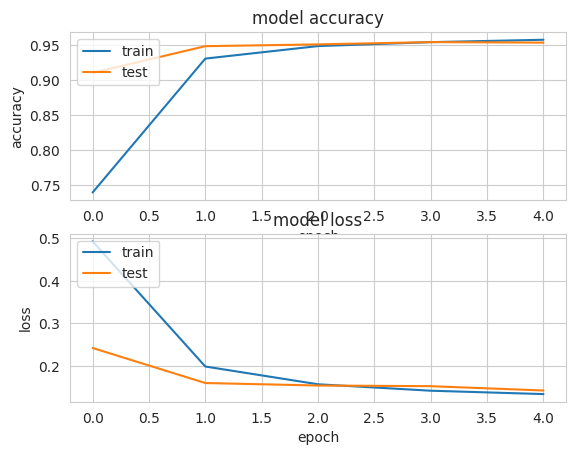

In [23]:
import matplotlib.pyplot as plt
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

 # summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


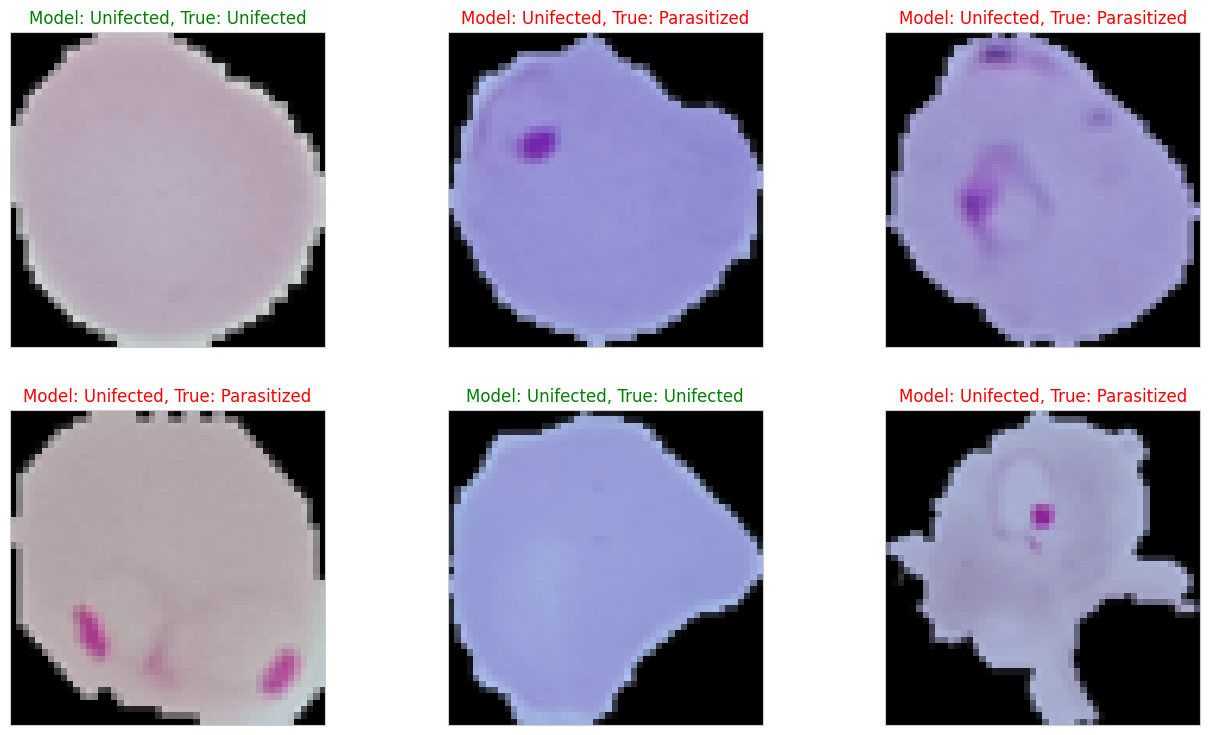

In [24]:
y_pred = model.predict(test_x)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
np.random.seed=1337

for i, idx in enumerate(np.random.choice(test_x.shape[0], size=6, replace=False)):
    ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_x[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = test_y[idx]

    true_label = 'Parasitized' if true_idx == 1 else  'Unifected'
    predicted_label = 'Parasitized' if pred_idx == 1 else  'Unifected'

    ax.set_title("Model: {}, True: {}".format(predicted_label, true_label), color=("green" if pred_idx == true_idx else "red"))